# Task A: Designing a Convolution Module for Variable Input Channels

程式碼參考:
https://medium.com/@SCU.Datascientist/python%E5%AD%B8%E7%BF%92%E7%AD%86%E8%A8%98-vgg16%E4%BB%8B%E7%B4%B9%E5%8F%8A%E5%AF%A6%E4%BD%9C-e05d659f242f


Explain:

1. design principles

2. references

3. additional costs (such as FLOPS or #PARAMS) 

and compare with naive models. 

## Needed packages and version

torchsummary

In [ ]:
# calculate channel-wise means and sds of train data
from ChannelWise_MeanSd import compute_dataset_mean_std
from torchvision import transforms
tmp_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
mu, sd = compute_dataset_mean_std('train.txt', tmp_transform)
print("Mean:", mu)
print("SD:", sd)

Mean: tensor([0.4799, 0.4597, 0.3874])
SD: tensor([0.2099, 0.2032, 0.1981])


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # to avoid matplotlib error
import random
import numpy as np
import torch
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Check pytorch and cuda version
print("Pytorch version:",torch.__version__)
print("Cuda version:",torch.version.cuda)
print("cuDNN version:",torch.backends.cudnn.version())
print("Check if cuda is available:",torch.cuda.is_available())
print("gpu device:", torch.cuda.get_device_name(0))

Pytorch version: 2.6.0+cu126
Cuda version: 12.6
cuDNN version: 90501
Check if cuda is available: True
gpu device: NVIDIA GeForce GTX 1660 Ti


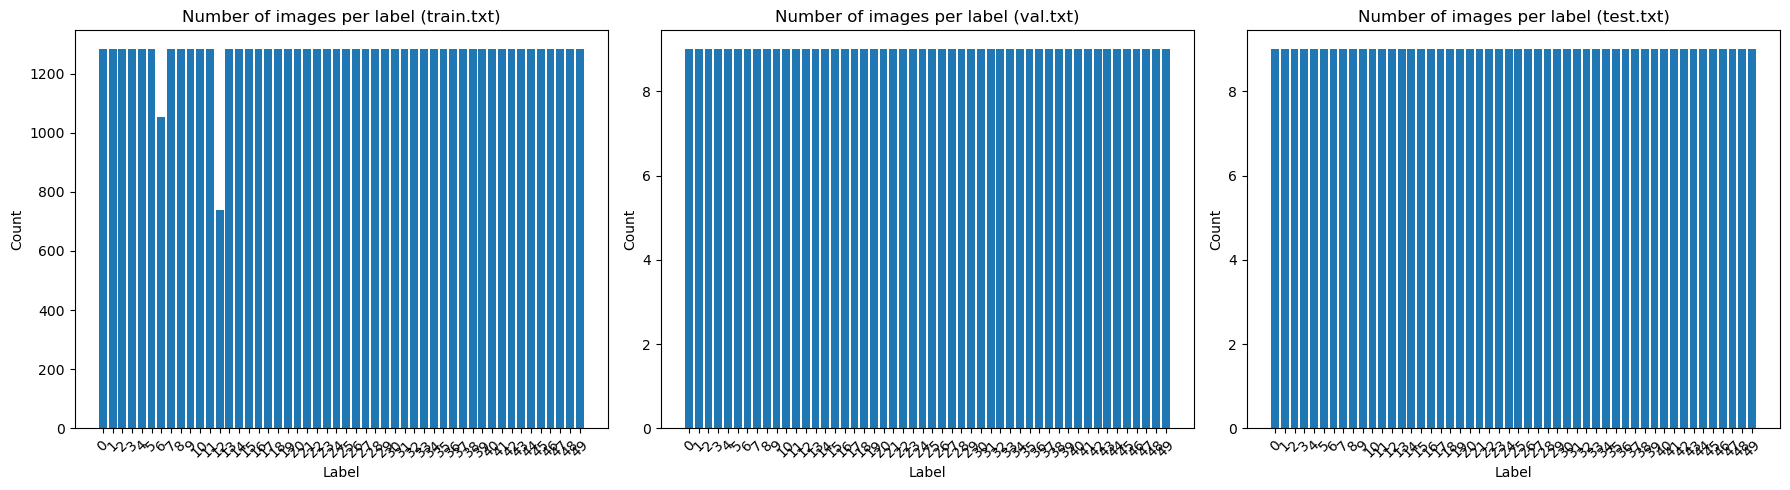

In [5]:
# 檢視資料的類別數量
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))  # 建立 1x3 子圖

for idx, name in enumerate(['train.txt', 'val.txt', 'test.txt']):
    with open(os.path.join(os.getcwd(), "images", name)) as Name_file:
        lines = Name_file.readlines()
        lines = [line.replace("\n", "").split(" ") for line in lines]

    targets = [line[1] for line in lines if len(line) > 1]
    count_table = Counter(targets)

    ax = axes[idx]
    ax.bar(count_table.keys(), count_table.values())
    ax.set_xlabel("Label")
    ax.set_ylabel("Count")
    ax.set_title(f"Number of images per label ({name})")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [ ]:
# 檢視資料的筆數
with open(os.path.join(os.getcwd(),"images","train.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# train data:",len(lines))
with open(os.path.join(os.getcwd(),"images","test.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# test data:",len(lines))
with open(os.path.join(os.getcwd(),"images","val.txt")) as Name_file:
    lines = Name_file.readlines()
    print("# validation data:",len(lines))

# train data: 63325
# test data: 450
# validation data: 450


In [ ]:
# 檢查模型架構
'''
from torchsummary import summary
from VGG16 import VGG16
myVGG16 = VGG16(50).to("cuda")
summary(myVGG16, input_size=(3, 224, 224))
'''

In [6]:
!cd

d:\NCKU\fourth_grade_spring\DeepLearning\assignment-1


模型訓練這次採用的是"Adam梯度下降"搭配"torch.optim.lr_scheduler.StepLR"

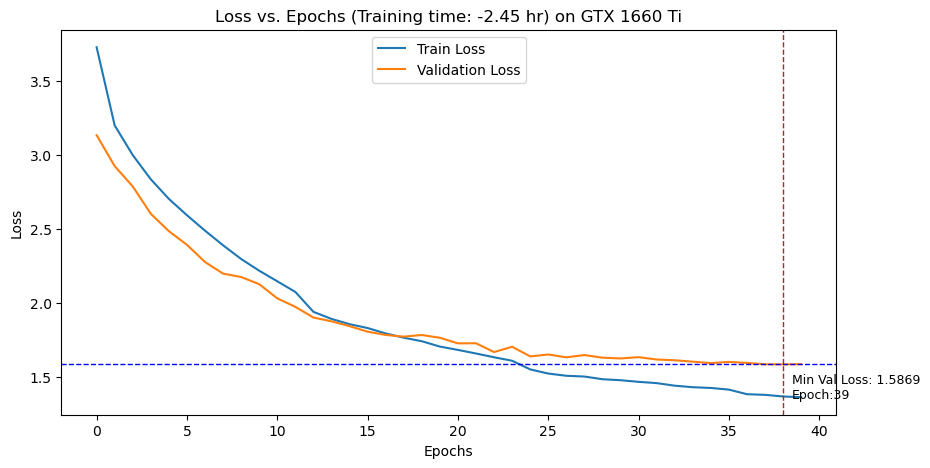

In [ ]:
'''
After running train_baseline.py in terminal, AlexNet_best_model.pth and AlexNet_train_log.json will be generated.
Training log records the training losses, validation losses, training time in second and learning rate.
'''
import json
with open("Alex_train_log.json", 'r') as log_file:
    log = json.load(log_file)

min_val_loss = min(log['val_losses'])
min_val_loss_epoch = log['val_losses'].index(min_val_loss)

plt.figure(figsize=(10, 5))
plt.title(f"Loss vs. Epochs (Training time: {round(log['training_time(second)']/3600, 2):.2f} hr) on GTX 1660 Ti")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(log['train_losses'], label='Train Loss')
plt.plot(log['val_losses'], label='Validation Loss')

plt.axvline(x=min_val_loss_epoch, color='brown', linestyle='--', linewidth=1)
plt.axhline(y=min_val_loss, color='blue', linestyle='--', linewidth=1)
plt.text(min_val_loss_epoch+0.5, min_val_loss-0.25,
         f'Min Val Loss: {min_val_loss:.4f}\nEpoch:{min_val_loss_epoch + 1}',
         color='black', fontsize=9, ha='left', va='bottom')
plt.legend()
plt.show()

In [7]:
# testing
from AlexNet import AlexNet
from torchvision import transforms
from ImageClassDataset import ImageClassDataset
from DataloaderWrapper import DataloaderWrapper
from test_TaskA import test_model
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4799, 0.4597, 0.3874], std=[0.2099, 0.2032, 0.1981])
])

test_loader = DataloaderWrapper(dataset=ImageClassDataset('test.txt', transform=transform),
                                batch_size=64, 
                                shuffle=False, 
                                num_workers=5, 
                                pin_memory=True).dataloader

model = AlexNet(num_classes=50).to("cuda")
model.load_state_dict(torch.load("AlexNet_best_model.pth"))
model.eval()
top1_acc, top3_acc, f1 = test_model(model, test_loader, "cuda")
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

初始化完成
Top-1 Accuracy: 0.5556
Top-3 Accuracy: 0.7733
Weighted F1 Score: 0.5468
